# **Learning-to-Optimize for BESS Day-Ahead Scheduling**

This notebook implements a **self-supervised Learning-to-Optimize (L2O)** framework for day-ahead scheduling of a residential battery energy storage system (BESS) coupled with rooftop solar PV under a **net metering** scheme.

The goal is to train a neural policy that directly maps 24-hour forecasts (solar generation, demand, electricity prices) to feasible and near-optimal battery schedules, replacing a slower mixed-integer programming (MIP) solver at inference time.

Key features of the approach:
- **Constraint satisfaction by construction** wherever possible (mode exclusivity via Gumbel-Softmax, power limits via Sigmoid scaling, SOC dynamics via deterministic unrolling, power balance via ReLU rectification).
- **Differentiable penalties** for SOC bounds and terminal conditions.
- **Self-supervised training** using the economic objective directly, without requiring pre-solved MIP labels.


## Imports and reproducibility

We use PyTorch for the neural network and training loop, CVXPY for the baseline MIP solver, and standard libraries for numerical computation and visualization. Random seeds are fixed for reproducibility.















In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import time
from dataclasses import dataclass
import cvxpy as cp

torch.manual_seed(42)
np.random.seed(42)

## Configuration flags

Two global flags control the experiment setup:

| Flag | Meaning |
|------|---------|
| `USE_NET_METERING` | If `True`, the system can export surplus energy to the grid and receive payment at the feed-in tariff. |
| `STOCHASTIC_TRAIN` | If `True`, Gaussian noise is added to the input forecasts during training to improve generalization. |


In [2]:
USE_NET_METERING = True
STOCHASTIC_TRAIN = True

## System parameters

The `BatterySystemParams` dataclass collects all physical and algorithmic parameters:

**Battery specifications**
- `battery_capacity` ($E_{\text{cap}}$) – total energy capacity [kWh].
- `max_charge_power`, `max_discharge_power` ($P_{\max}$) – power rating [kW].
- `charge_efficiency`, `discharge_efficiency` ($\eta$) – one-way round-trip efficiency.
- `initial_soc`, `final_soc` – SOC boundary conditions as fractions of capacity.

**Economic parameters**
- `feed_in_tariff_ratio` ($\alpha$) – sell price is $\alpha \times$ buy price.

**Training hyperparameters**
- `soc_penalty_weight` ($\lambda_{\text{soc}}$) – weight on SOC bound violations.
- `terminal_penalty_weight` ($\lambda_{\text{term}}$) – weight on terminal SOC mismatch.
- `temperature_init`, `temperature_min`, `temperature_decay` – Gumbel-Softmax temperature schedule for mode selection.


In [3]:
@dataclass
class BatterySystemParams:
    T: int = 24
    battery_capacity: float = 10.0
    max_charge_power: float = 3.0
    max_discharge_power: float = 3.0
    charge_efficiency: float = 0.95
    discharge_efficiency: float = 0.95
    initial_soc: float = 0.5
    final_soc: float = 0.5
    solar_capacity: float = 5.0
    feed_in_tariff_ratio: float = 0.3
    soc_penalty_weight: float = 20.0
    terminal_penalty_weight: float = 10.0
    track_penalty_weight: float = 1.0
    temperature_init: float = 5.0
    temperature_min: float = 0.1
    temperature_decay: float = 0.99

## Training data generation

The function `generate_training_data_netmeter` creates synthetic 24-hour scenarios for training. Each sample consists of:

1. **Solar profile** – a sinusoidal curve peaking around midday with additive Gaussian noise.
2. **Demand profile** – a bimodal pattern with a morning peak (around 7 h) and an evening peak (around 19 h), plus random baseline load.
3. **Buy price profile** – a time-of-use tariff with higher prices during peak hours (16–21 h) and lower off-peak prices.
4. **Sell price profile** – a fraction (`feed_in_ratio`) of the buy price, reduced further around midday to reflect typical grid conditions when solar supply is abundant.

All profiles are clipped to ensure non-negative values and converted to PyTorch tensors.


In [4]:
def generate_training_data_netmeter(num_samples, T=24, feed_in_ratio=0.3):
    time_hours = np.arange(T)
    solar_profiles = np.zeros((num_samples, T))
    demand_profiles = np.zeros((num_samples, T))
    price_buy_profiles = np.zeros((num_samples, T))
    price_sell_profiles = np.zeros((num_samples, T))

    for i in range(num_samples):
        solar_peak = np.random.uniform(3.0, 5.0)
        solar = solar_peak * np.maximum(0, np.sin(np.pi * (time_hours - 6) / 12))
        solar = solar + np.random.normal(0, 0.2, T)
        solar_profiles[i] = np.maximum(0, solar)

        morning_peak = np.random.uniform(2.0, 3.0)
        evening_peak = np.random.uniform(3.0, 4.5)
        demand = morning_peak * np.exp(-((time_hours - 7)**2) / 8) + \
                 evening_peak * np.exp(-((time_hours - 19)**2) / 8) + \
                 np.random.uniform(0.5, 1.0)
        demand = demand + np.random.normal(0, 0.1, T)
        demand_profiles[i] = np.maximum(0, demand)

        base_price = np.random.uniform(0.10, 0.15)
        peak_price = np.random.uniform(0.25, 0.35)
        is_peak = (time_hours >= 16) & (time_hours <= 21)
        price_buy = np.where(is_peak, peak_price, base_price)
        price_buy = price_buy + np.random.normal(0, 0.02, T)
        price_buy_profiles[i] = np.maximum(0.05, price_buy)

        price_sell = price_buy * feed_in_ratio
        midday_factor = np.exp(-((time_hours - 12)**2) / 16)
        price_sell = price_sell * (1 - 0.3 * midday_factor)
        price_sell_profiles[i] = np.maximum(0.02, price_sell)

    return (torch.from_numpy(solar_profiles).float(),
            torch.from_numpy(demand_profiles).float(),
            torch.from_numpy(price_buy_profiles).float(),
            torch.from_numpy(price_sell_profiles).float())


## Baseline MIP solver (CVXPY)

To establish a ground-truth reference, we solve the full mixed-integer problem formulation using **CVXPY** with CBC (Coin-or-branch-and-cut) solver. This solver returns **globally optimal** schedules but has computational cost that grows rapidly with problem size, making it impractical for real-time control.

The MIP solver is used to:
1. Generate reference optimal solutions for evaluation.
2. Compute the **optimality gap** of the learned L2O policy.
3. Assess **feasibility** of neural network predictions.

The `MIPSolverNetMetering` class encapsulates the CVXPY formulation and can solve individual scenarios or batches of scenarios.


### Decision variables in the MIP

For each time step $t \in \{0, \ldots, T-1\}$, the solver optimizes:

**Binary mode variables**
- $z^{\text{ch}}_t, z^{\text{dis}}_t, z^{\text{idle}}_t \in \{0, 1\}$ – operating mode indicators (exactly one is active per timestep).

**Continuous power variables**
- $p^{\text{ch}}_t, p^{\text{dis}}_t \geq 0$ – charge and discharge power [kW].
- $p^{\text{import}}_t, p^{\text{export}}_t \geq 0$ – grid power (under net metering).

**State variables**
- $\text{soc}_t \in [0, E_{\text{cap}}]$ – state of charge at time $t$ [kWh].

### Objective function

With net metering enabled (`USE_NET_METERING = True`):

$$
\min \quad \sum_{t=0}^{T-1} \left( p^{\text{import}}_t \cdot \pi^{\text{buy}}_t - p^{\text{export}}_t \cdot \pi^{\text{sell}}_t \right)
$$

This minimizes net electricity costs, where importing power incurs cost and exporting energy provides revenue.


### Constraints in the MIP

**1. Mode exclusivity**
$$z^{\text{ch}}_t + z^{\text{dis}}_t + z^{\text{idle}}_t = 1, \quad \forall t$$

The battery operates in exactly one mode at each timestep.

**2. Power limits (Big-M constraints)**
$$
p^{\text{ch}}_t \leq P_{\max} \cdot z^{\text{ch}}_t, \quad
p^{\text{dis}}_t \leq P_{\max} \cdot z^{\text{dis}}_t, \quad \forall t
$$

Power is nonzero only in the active mode.

**3. SOC dynamics**
$$\text{soc}_{t+1} = \text{soc}_t + \eta_{\text{ch}} \cdot p^{\text{ch}}_t - \frac{p^{\text{dis}}_t}{\eta_{\text{dis}}}, \quad \forall t$$

Energy balance with charge/discharge efficiency.

**4. SOC bounds**
$$0 \leq \text{soc}_t \leq E_{\text{cap}}, \quad \forall t$$

**5. Terminal condition (cyclic)**
$$\text{soc}_T = \text{soc}_0 = 0.5 \cdot E_{\text{cap}}$$

The battery starts and ends at 50% capacity (or tolerance = 0 for exact equality).

**6. Power balance**
$$p^{\text{import}}_t - p^{\text{export}}_t = d_t - s_t + p^{\text{ch}}_t - p^{\text{dis}}_t, \quad \forall t$$

All power flows must sum to zero at each timestep.


In [5]:
class MIPSolverNetMetering:
    def __init__(self, params):
        self.params = params
        self.T = params.T

    def solve_batch(self, solar_batch, demand_batch, price_buy_batch, price_sell_batch):
        batch_size = solar_batch.shape[0]
        results = []

        for i in range(batch_size):
            result = self.solve(
                solar_batch[i].numpy(),
                demand_batch[i].numpy(),
                price_buy_batch[i].numpy(),
                price_sell_batch[i].numpy()
            )
            results.append(result)

        return {
            'cost': torch.tensor([r['cost'] for r in results]),
            'solve_time': torch.tensor([r['solve_time'] for r in results]),
            'power_charge': torch.stack([torch.tensor(r['power_charge']) for r in results]),
            'power_discharge': torch.stack([torch.tensor(r['power_discharge']) for r in results]),
            'soc': torch.stack([torch.tensor(r['soc']) for r in results]),
            'net_power': torch.stack([torch.tensor(r['net_power']) for r in results]),
            'mode': torch.stack([torch.tensor(r['mode']) for r in results])
        }

    def solve(self, solar, demand, price_buy, price_sell, verbose=False):
        T = self.T
        params = self.params
        start_time = time.time()

        z_charge = cp.Variable(T, boolean=True)
        z_discharge = cp.Variable(T, boolean=True)
        z_idle = cp.Variable(T, boolean=True)
        p_charge = cp.Variable(T, nonneg=True)
        p_discharge = cp.Variable(T, nonneg=True)
        soc = cp.Variable(T + 1, nonneg=True)
        p_import = cp.Variable(T, nonneg=True)
        p_export = cp.Variable(T, nonneg=True)

        constraints = []

        for t in range(T):
            constraints.append(z_charge[t] + z_discharge[t] + z_idle[t] == 1)
            constraints.append(p_charge[t] <= params.max_charge_power * z_charge[t])
            constraints.append(p_discharge[t] <= params.max_discharge_power * z_discharge[t])

        constraints.append(soc[0] == params.initial_soc * params.battery_capacity)
        for t in range(T):
            constraints.append(
                soc[t + 1] == soc[t] +
                params.charge_efficiency * p_charge[t] -
                p_discharge[t] / params.discharge_efficiency
            )

        for t in range(T + 1):
            constraints.append(soc[t] <= params.battery_capacity)

        terminal_soc_target = params.final_soc * params.battery_capacity
        #tolerance = 0.05 * params.battery_capacity
        tolerance = 0
        constraints.append(cp.abs(soc[T] - terminal_soc_target) <= tolerance)

        for t in range(T):
            net_power = demand[t] - solar[t] + p_charge[t] - p_discharge[t]
            constraints.append(net_power == p_import[t] - p_export[t])

        if USE_NET_METERING:
            objective = cp.Minimize(
                cp.sum(cp.multiply(p_import, price_buy)) -
                cp.sum(cp.multiply(p_export, price_sell))
            )
        else:
            objective = cp.Minimize(cp.sum(cp.multiply(cp.pos(net_power), price_buy)))

        problem = cp.Problem(objective, constraints)

        try:
            problem.solve(solver=cp.CBC, verbose=verbose)
        except:
            try:
                problem.solve(solver=cp.GLPK_MI, verbose=verbose)
            except:
                problem.solve(verbose=verbose)

        solve_time = time.time() - start_time

        if problem.status == cp.OPTIMAL or problem.status == cp.OPTIMAL_INACCURATE:
            return {
                'status': 'optimal',
                'cost': problem.value,
                'solve_time': solve_time,
                'power_charge': np.array(p_charge.value),
                'power_discharge': np.array(p_discharge.value),
                'soc': np.array(soc.value),
                'net_power': demand - solar + np.array(p_charge.value) - np.array(p_discharge.value),
                'mode': np.stack([
                    np.array(z_charge.value).round(),
                    np.array(z_discharge.value).round(),
                    np.array(z_idle.value).round()
                ], axis=-1)
            }
        else:
            net = demand - solar
            if USE_NET_METERING:
                fallback_cost = float(np.sum(np.maximum(0, net) * price_buy) -
                                      np.sum(np.maximum(0, -net) * price_sell))
            else:
                fallback_cost = float(np.sum(np.maximum(0, net) * price_buy))
            return {
                'status': 'failed',
                'cost': fallback_cost,
                'solve_time': solve_time,
                'power_charge': np.zeros(T),
                'power_discharge': np.zeros(T),
                'soc': np.ones(T+1) * params.initial_soc * params.battery_capacity,
                'net_power': net,
                'mode': np.stack([np.zeros(T), np.zeros(T), np.ones(T)], axis=-1)
            }


## Learning-to-Optimize (L2O) neural policy

The neural policy replaces the MIP solver with a **self-supervised** deep learning model that maps 24-hour forecasts directly to feasible battery schedules.

The key design principle is **constraint satisfaction by construction**: wherever possible, constraints are embedded directly into the architecture (via Gumbel-Softmax, Sigmoid scaling, deterministic SOC unrolling, and ReLU rectification). Remaining constraints are enforced through differentiable penalties in the loss function.

The model consists of:
1. A shared **encoder** for temporal feature extraction.
2. A **mode head** for discrete operating mode selection (charge / discharge / idle).
3. A **power head** for continuous charge/discharge power prediction.
4. A **deterministic SOC unroller** that computes the state-of-charge trajectory exactly from the predicted powers.

All components are differentiable and can be trained end-to-end using gradient descent.


### Input features and normalization

The model receives four normalized time series stacked into a single feature vector:

$$
\mathbf{x}_{\text{in}} = \left[
\frac{\mathbf{s}}{\bar{s}}, \;
\frac{\mathbf{d}}{\bar{d}}, \;
\frac{\boldsymbol{\pi}^{\text{buy}}}{\bar{\pi}^{\text{buy}}}, \;
\frac{\boldsymbol{\pi}^{\text{buy}} - \boldsymbol{\pi}^{\text{sell}}}{\bar{\pi}^{\text{spread}}}
\right] \in \mathbb{R}^{4T}
$$

where:
- $\mathbf{s}$ and $\mathbf{d}$ are normalized by typical peak values (solar capacity and baseline demand);
- $\boldsymbol{\pi}^{\text{buy}}$ is normalized by its daily maximum to ensure scale invariance;
- $\boldsymbol{\pi}^{\text{buy}} - \boldsymbol{\pi}^{\text{sell}}$ (the price spread) is normalized by its maximum absolute value to ensure it lies within $[-1, 1]$.


This ensures comparable feature scales and helps gradient-based learning converge faster.


### Encoder

The encoder is a two-layer fully connected network with normalization and regularization:

| Layer | Operation | Output dim |
|-------|-----------|-----------|
| Input | Normalized forecasts | $4T = 96$ |
| Linear 1 | $96 \to 768$ | $768$ |
| LayerNorm | Normalize activations | $768$ |
| ReLU | Non-linearity | $768$ |
| Dropout | 10% regularization | $768$ |
| Linear 2 | $768 \to 768$ | $768$ |
| LayerNorm | Normalize activations | $768$ |
| ReLU | Non-linearity | $768$ |
| Dropout | 10% regularization | $768$ |

The encoder extracts rich temporal patterns from the input forecasts, which are then used by both the mode and power heads.


### Mode head (discrete mode selection via Gumbel-Softmax)

The mode head predicts a categorical operating mode (charge, discharge, or idle) for each timestep:

$$\text{mode}_t \in \{\text{charge}, \text{discharge}, \text{idle}\}$$

**During training**, the mode is sampled using **Gumbel-Softmax** for differentiability:

$$\mathbf{z}_t^{\text{soft}} = \text{softmax}\left(\frac{\mathbf{h}_t + \mathbf{g}_t}{\tau}\right), \quad \mathbf{g}_t \sim \text{Gumbel}(0, 1)$$

**During inference**, a hard one-hot vector is obtained via argmax and a **straight-through estimator** (gradients flow from soft, but forward pass uses hard).

**Bias initialization** prevents the network from defaulting to always-idle:
- Charge mode bias: $+0.2$
- Discharge mode bias: $+0.2$
- Idle mode bias: $-0.4$

This encourages active exploration during early training despite SOC penalties.

**Temperature annealing** smoothly transitions from soft (high temperature) to hard (low temperature) decisions:

$$\tau(\text{epoch}) = \tau_{\text{init}} \left(1 - \frac{\text{epoch}}{N_{\text{epochs}}}\right) + \tau_{\text{min}} \frac{\text{epoch}}{N_{\text{epochs}}}$$

with $\tau_{\text{init}} = 5.0$ and $\tau_{\text{min}} = 0.1$.


### Power head (continuous power prediction)

The power head outputs continuous charge and discharge setpoints, constrained to $[0, P_{\max}]$:

1. The head produces unconstrained logits for each timestep.
2. A **Sigmoid** activation maps them to $(0, 1)$.
3. The result is scaled by $P_{\max}$:

$$p_t^{\text{ch/dis}} = P_{\max} \cdot \sigma(\text{NetworkOutput}_t)$$

This ensures powers remain within physical limits.

**Mode masking** enforces the mixed-integer structure: the predicted power is multiplied by the active mode indicator, so power is nonzero only when that mode is active:

$$\tilde{p}_t^{\text{ch}} = \text{mode}_t^{\text{ch}} \cdot p_t^{\text{ch}}$$

where $\text{mode}_t^{\text{ch}} \in \{0, 1\}$ is the charge indicator from the mode head.


### SOC computation (deterministic unrolling)

The state of charge is **not** predicted directly by the network. Instead, it is computed deterministically from the predicted powers using the energy balance equation:

$$\text{SOC}_{t+1} = \text{SOC}_t + \eta_{\text{ch}} \cdot p_t^{\text{ch}} - \frac{p_t^{\text{dis}}}{\eta_{\text{dis}}}$$

This ensures the SOC dynamics constraint is satisfied **exactly by construction**, with zero constraint violation. Gradients are backpropagated through the unrolling via reverse-mode automatic differentiation (backpropagation through time).

The algorithm:
1. Initialize SOC to $\text{SOC}_0 = 0.5 \cdot E_{\text{cap}}$.
2. For each $t = 0, \ldots, T-1$, update SOC by adding the net charge.
3. Return the full SOC trajectory (a list of $T+1$ values: initial + one per timestep).


### Loss function

The training objective combines the economic cost with penalties for constraint violations:

$$\mathcal{L} = \mathcal{L}_{\text{econ}} + \lambda_{\text{soc}} \mathcal{L}_{\text{soc}} + \lambda_{\text{term}} \mathcal{L}_{\text{term}} + \lambda_{\text{track}} \mathcal{L}_{\text{track}}$$

**Economic loss** (net electricity cost):
$$\mathcal{L}_{\text{econ}} = \sum_{t=0}^{T-1} \left( p_t^{\text{import}} \cdot \pi_t^{\text{buy}} - p_t^{\text{export}} \cdot \pi_t^{\text{sell}} \right)$$

where import and export are derived from the net power via:
$$p_t^{\text{import}} = \text{ReLU}(n_t), \quad p_t^{\text{export}} = \text{ReLU}(-n_t)$$

**SOC bounds penalty** (ReLU on violations):
$$\mathcal{L}_{\text{soc}} = \frac{1}{T+1} \sum_{t=0}^{T} \left[ \text{ReLU}(-\text{SOC}_t) + \text{ReLU}(\text{SOC}_t - E_{\text{cap}}) \right]$$

This penalizes violations of $0 \leq \text{SOC}_t \leq E_{\text{cap}}$ while ignoring feasible SOC values.

**Terminal penalty** (Huber loss for cyclic condition):
$$\mathcal{L}_{\text{term}} = \text{SmoothL1}(\text{SOC}_T, \text{SOC}_0)$$

SmoothL1 is quadratic for small deviations and linear for large ones, providing stable gradients.

**Tracking penalty** (optional): enforces power balance by penalizing residuals between predicted and computed net power. This is primarily for numerical stability.

**Hyperparameters:**
- $\lambda_{\text{soc}} = 20.0$ – SOC bounds weight
- $\lambda_{\text{term}} = 10.0$ – terminal condition weight
- $\lambda_{\text{track}} = 1.0$ – tracking weight


### Temperature annealing for Gumbel-Softmax

The Gumbel-Softmax temperature $\tau$ is annealed linearly over the training epochs:

$$\tau(\text{epoch}) = \tau_{\text{init}} \left(1 - \frac{\text{epoch}}{N_{\text{epochs}}}\right) + \tau_{\text{min}} \frac{\text{epoch}}{N_{\text{epochs}}}$$

- **Early training** ($\tau$ high): modes are soft (smooth distribution), allowing gradients to flow easily.
- **Late training** ($\tau$ low): modes sharpen towards one-hot, producing discrete decisions.

This schedule is called before each epoch and should be updated during training.


In [6]:
class L2O(nn.Module):
    def __init__(self, params, hidden_dim=768):
        super().__init__()
        self.params = params
        self.T = params.T
        self.temperature = params.temperature_init

        input_dim = 4 * self.T


        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        self.mode_head = nn.Linear(hidden_dim, self.T * 3)
        self.power_head = nn.Linear(hidden_dim, self.T * 2)

        with torch.no_grad():
            self.mode_head.bias.data = self.mode_head.bias.data.reshape(self.T, 3)
            self.mode_head.bias.data[:, 0] = 0.2
            self.mode_head.bias.data[:, 1] = 0.2
            self.mode_head.bias.data[:, 2] = -0.4
            self.mode_head.bias.data = self.mode_head.bias.data.reshape(-1)

    def forward(self, solar, demand, price_buy, price_sell):
        batch_size = solar.shape[0]

        price_spread = price_buy - price_sell
        inputs = torch.cat([
            solar / self.params.solar_capacity,
            demand / 5.0,
            price_buy / (price_buy.max(dim=1, keepdim=True)[0] + 1e-6),
            price_spread / (price_spread.max(dim=1, keepdim=True)[0] + 1e-6)
        ], dim=1)

        hidden = self.encoder(inputs)
        mode_logits = self.mode_head(hidden).reshape(batch_size, self.T, 3)

        if self.training:
            mode = F.gumbel_softmax(mode_logits, tau=self.temperature, hard=True)
        else:
            mode = F.one_hot(mode_logits.argmax(dim=-1), num_classes=3).float()

        powers = self.power_head(hidden).reshape(batch_size, self.T, 2)
        power_charge_raw = torch.sigmoid(powers[..., 0]) * self.params.max_charge_power
        power_discharge_raw = torch.sigmoid(powers[..., 1]) * self.params.max_discharge_power

        power_charge = mode[..., 0] * power_charge_raw
        power_discharge = mode[..., 1] * power_discharge_raw

        soc = self.compute_soc(power_charge, power_discharge)
        net_power = demand - solar + power_charge - power_discharge

        return {
            'power_charge': power_charge,
            'power_discharge': power_discharge,
            'mode': mode,
            'soc': soc,
            'net_power': net_power
        }

    def compute_soc(self, power_charge, power_discharge):
        batch_size = power_charge.shape[0]
        device = power_charge.device

        soc_init = self.params.initial_soc * self.params.battery_capacity
        soc = torch.full((batch_size,), soc_init, device=device)

        soc_trajectory = [soc.clone()]

        for t in range(self.T):
            soc_change = (power_charge[:, t] * self.params.charge_efficiency -
                          power_discharge[:, t] / self.params.discharge_efficiency)
            soc = soc + soc_change
            soc_trajectory.append(soc.clone())

        return torch.stack(soc_trajectory, dim=1)[:, 1:]

    def compute_loss(self, solar, demand, price_buy, price_sell):
        output = self.forward(solar, demand, price_buy, price_sell)
        batch_size = solar.shape[0]
        device = solar.device

        net_power = output['net_power']
        if USE_NET_METERING:
            import_power = F.relu(net_power)
            export_power = F.relu(-net_power)
            import_cost = (import_power * price_buy).sum(dim=1)
            export_revenue = (export_power * price_sell).sum(dim=1)
            economic_cost = import_cost - export_revenue
        else:
            economic_cost = (F.relu(net_power) * price_buy).sum(dim=1)

        soc_full = torch.cat([torch.full((batch_size, 1), self.params.initial_soc * self.params.battery_capacity, device=device),
                              output['soc']], dim=1)
        lower_viol = F.relu(0 - soc_full)
        upper_viol = F.relu(soc_full - self.params.battery_capacity)
        soc_violations = (lower_viol + upper_viol).mean(dim=1)

        final_soc = output['soc'][:, -1]
        target_soc = self.params.final_soc * self.params.battery_capacity
        terminal_penalty = F.smooth_l1_loss(final_soc, torch.full_like(final_soc, target_soc), reduction='none')

        computed_net = demand - solar + output['power_charge'] - output['power_discharge']
        track_residual = (net_power - computed_net).pow(2).mean(dim=1)

        total_loss = (
            economic_cost.mean() +
            self.params.soc_penalty_weight * soc_violations.mean() +
            self.params.terminal_penalty_weight * terminal_penalty.mean() +
            self.params.track_penalty_weight * track_residual.mean()
        )

        return total_loss

    def anneal_temperature(self, epoch, total_epochs):
        progress = epoch / total_epochs
        self.temperature = self.params.temperature_init * (1 - progress) + self.params.temperature_min * progress
        return self.temperature

## Training strategy

The L2O model is trained end-to-end using **self-supervised learning**: the loss is computed directly from the economic objective and constraint penalties, without requiring pre-solved MIP solutions as labels.

Key elements of the training strategy:

**Optimizer and learning rate schedule**
- **AdamW** optimizer with weight decay ($10^{-4}$) for regularization.
- **OneCycleLR** scheduler: learning rate ramps from $10^{-4}$ to $10^{-3}$ over the first 10% of epochs, then decays to $10^{-5}$ via a cosine schedule. This helps escape flat regions in the constrained loss landscape.

**Stochastic input perturbations**
- When `STOCHASTIC_TRAIN = True`, 5% Gaussian noise is added to forecasts during training.
- This prevents overfitting to specific daily profiles and encourages generalization.

**Gradient clipping**
- Gradients are clipped to a maximum norm of 1.0 to prevent exploding gradients from hard constraint penalties.

**Temperature annealing**
- The Gumbel-Softmax temperature is annealed each epoch from $\tau_{\text{init}} = 5.0$ to $\tau_{\text{min}} = 0.1$, gradually sharpening mode decisions.

**Validation monitoring**
- A small validation set (32 samples) is held out and solved with the MIP solver at the start of training.
- Every 100 epochs, the L2O policy is evaluated on this set, reporting:
  - **Optimality gap**: percentage cost increase relative to MIP solution.
  - **Feasibility rate**: percentage of SOC values within $[0, E_{\text{cap}}]$.


### Training hyperparameters

| Parameter | Value |
|-----------|-------|
| Training samples | 5,000 |
| Training epochs | 1,500 |
| Batch size | 64 |
| Optimizer | AdamW |
| Base learning rate | $10^{-4}$ |
| Max learning rate | $10^{-3}$ |
| Weight decay | $10^{-4}$ |
| Gradient clipping | max norm = 1.0 |
| Stochastic noise level | 5% |
| SOC penalty weight $\lambda_{\text{soc}}$ | 20.0 |
| Terminal penalty weight $\lambda_{\text{term}}$ | 10.0 |
| Validation set size | 32 |
| Logging frequency | every 100 epochs |


In [7]:
def train_l2o_model(model, train_data, params, n_epochs=1500, batch_size=64):
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=1e-3, total_steps=n_epochs, pct_start=0.1
    )

    solar_train, demand_train, price_buy_train, price_sell_train = train_data
    n_train = solar_train.shape[0]
    n_batches = (n_train + batch_size - 1) // batch_size

    val_idx = torch.randperm(n_train)[:32]
    val_solar, val_demand, val_buy, val_sell = [d[val_idx] for d in train_data]
    mip_solver = MIPSolverNetMetering(params)
    val_mip = mip_solver.solve_batch(val_solar, val_demand, val_buy, val_sell)

    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0

        perm = torch.randperm(n_train)

        for i in range(n_batches):
            start_idx = i * batch_size
            end_idx = min(start_idx + batch_size, n_train)
            batch_idx = perm[start_idx:end_idx]
            s, d, pb, ps = [train_data[j][batch_idx] for j in range(4)]

            if STOCHASTIC_TRAIN:
                noise_scale = 0.05
                s = s + torch.randn_like(s) * noise_scale * s.mean(dim=1, keepdim=True)
                d = d + torch.randn_like(d) * noise_scale * d.mean(dim=1, keepdim=True)
                pb = pb + torch.randn_like(pb) * noise_scale * pb.mean(dim=1, keepdim=True)
                ps = ps + torch.randn_like(ps) * noise_scale * ps.mean(dim=1, keepdim=True)
                s, d, pb, ps = [torch.clamp(x, 0) for x in [s, d, pb, ps]]

            loss = model.compute_loss(s, d, pb, ps)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            epoch_loss += loss.item()

        model.anneal_temperature(epoch, n_epochs)
        scheduler.step()

        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss/n_batches:.4f}")
            model.eval()
            with torch.no_grad():
                val_out = model.forward(val_solar, val_demand, val_buy, val_sell)
                val_net = val_out['net_power']
                if USE_NET_METERING:
                    val_cost = (F.relu(val_net) * val_buy).sum(1) - (F.relu(-val_net) * val_sell).sum(1)
                else:
                    val_cost = (F.relu(val_net) * val_buy).sum(1)
            gap = ((val_cost - val_mip['cost']) / (val_mip['cost'] + 1e-6)).mean().item() * 100
            feas = ((val_out['soc'] >= 0) & (val_out['soc'] <= params.battery_capacity)).float().mean().item() * 100
            print(f"Val Gap: {gap:.2f}%, Feasibility: {feas:.1f}%")

## Run training

The following cell:
1. Instantiates the system parameters.
2. Generates 5,000 synthetic training scenarios.
3. Creates the L2O model.
4. Trains for 1,500 epochs with validation logging every 100 epochs.


In [8]:
params = BatterySystemParams()
train_data = generate_training_data_netmeter(num_samples=5000)
model = L2O(params)
train_l2o_model(model, train_data, params)

Epoch 100/1500, Loss: 4.4370
Val Gap: 7.26%, Feasibility: 91.7%
Epoch 200/1500, Loss: 4.3547
Val Gap: 7.62%, Feasibility: 100.0%
Epoch 300/1500, Loss: 4.3233
Val Gap: 6.71%, Feasibility: 87.5%
Epoch 400/1500, Loss: 4.3109
Val Gap: 7.14%, Feasibility: 100.0%
Epoch 500/1500, Loss: 4.3139
Val Gap: 6.89%, Feasibility: 98.7%
Epoch 600/1500, Loss: 4.3112
Val Gap: 7.02%, Feasibility: 91.7%
Epoch 700/1500, Loss: 4.2967
Val Gap: 6.92%, Feasibility: 92.2%
Epoch 800/1500, Loss: 4.6161
Val Gap: 8.54%, Feasibility: 100.0%
Epoch 900/1500, Loss: 4.3031
Val Gap: 6.87%, Feasibility: 91.7%
Epoch 1000/1500, Loss: 4.2944
Val Gap: 6.84%, Feasibility: 91.9%
Epoch 1100/1500, Loss: 4.3367
Val Gap: 6.73%, Feasibility: 92.8%
Epoch 1200/1500, Loss: 4.3268
Val Gap: 6.61%, Feasibility: 99.7%
Epoch 1300/1500, Loss: 4.2776
Val Gap: 6.42%, Feasibility: 99.5%
Epoch 1400/1500, Loss: 4.2733
Val Gap: 6.26%, Feasibility: 98.2%
Epoch 1500/1500, Loss: 4.2798
Val Gap: 6.23%, Feasibility: 99.0%


## Evaluation and comparison

After training, the L2O model is evaluated against the MIP solver on a held-out test set. This section compares:

1. **Solution quality** – optimality gap relative to MIP solutions.
2. **Computational speed** – wall-clock time per instance.
3. **Feasibility** – percentage of solutions with valid SOC trajectories.
4. **Operating decisions** – mode (charge/discharge/idle) and power setpoints.

Key metrics:
- **Optimality gap** = (L2O cost − MIP cost) / MIP cost × 100%
- **Speedup** = MIP solve time / L2O solve time
- **Feasibility rate** = # of instances with SOC ∈ [0, E_cap] / total instances


In [34]:
def set_seed(seed=30):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def compare_methods(model, test_data, params, num_instances=100):
    print("=" * 60)
    print(f"COMPARING L2O vs MIP ON {num_instances} TEST INSTANCES")
    print("=" * 60)

    solar_test, demand_test, price_buy_test, price_sell_test = test_data

    solar_test = solar_test[:num_instances]
    demand_test = demand_test[:num_instances]
    price_buy_test = price_buy_test[:num_instances]
    price_sell_test = price_sell_test[:num_instances]

    print("\n[1/2] Solving with MIP Solver...")
    mip_solver = MIPSolverNetMetering(params)
    mip_start = time.time()
    mip_results = mip_solver.solve_batch(solar_test, demand_test, price_buy_test, price_sell_test)
    mip_total_time = time.time() - mip_start

    print("[2/2] Solving with L2O Model...")
    model.eval()
    l2o_start = time.time()
    with torch.no_grad():
        l2o_results = model.forward(solar_test, demand_test, price_buy_test, price_sell_test)

        net_power = l2o_results['net_power']
        if USE_NET_METERING:
            import_power = F.relu(net_power)
            export_power = F.relu(-net_power)
            l2o_costs = (import_power * price_buy_test).sum(dim=1) - (export_power * price_sell_test).sum(dim=1)
        else:
            l2o_costs = (F.relu(net_power) * price_buy_test).sum(dim=1)
    l2o_total_time = time.time() - l2o_start

    mip_costs = mip_results['cost']
    cost_gaps = ((l2o_costs - mip_costs) / (mip_costs.abs() + 1e-6)) * 100

    l2o_soc_feasible = (
        (l2o_results['soc'] >= -0.01) &
        (l2o_results['soc'] <= params.battery_capacity + 0.01)
    ).all(dim=1)

    print("\n" + "=" * 60)
    print("RESULTS SUMMARY")
    print("=" * 60)

    print(f"\nCost Comparison:")
    print(f"  MIP Average Cost:     ${mip_costs.mean():.2f}")
    print(f"  L2O Average Cost:     ${l2o_costs.mean():.2f}")
    print(f"  Average Gap:          {cost_gaps.mean():.2f}%")
    print(f"  Median Gap:           {cost_gaps.median():.2f}%")
    print(f"  Max Gap:              {cost_gaps.max():.2f}%")
    print(f"  Min Gap:              {cost_gaps.min():.2f}%")

    print(f"\nSolve Time:")
    print(f"  MIP Total Time:       {mip_total_time:.2f}s")
    print(f"  MIP Avg per instance: {mip_total_time/num_instances:.3f}s")
    print(f"  L2O Total Time:       {l2o_total_time:.4f}s")
    print(f"  L2O Avg per instance: {l2o_total_time/num_instances:.6f}s")
    print(f"  Speedup:              {mip_total_time/l2o_total_time:.1f}x")

    print(f"\nFeasibility:")
    print(f"  L2O Feasible:         {l2o_soc_feasible.sum()}/{num_instances} ({l2o_soc_feasible.float().mean()*100:.1f}%)")

    return {
        'mip_results': mip_results,
        'l2o_results': l2o_results,
        'mip_costs': mip_costs,
        'l2o_costs': l2o_costs,
        'cost_gaps': cost_gaps,
        'mip_time': mip_total_time,
        'l2o_time': l2o_total_time
    }
instance_idx = 0

print("\n" + "="*60)
print("Generating 50 test instances...")
test_data = generate_training_data_netmeter(num_samples=500, T=params.T)

print("Running comparison on trained model...")
comparison_results = compare_methods(model, test_data, params, num_instances=500)


Generating 50 test instances...
Running comparison on trained model...
COMPARING L2O vs MIP ON 500 TEST INSTANCES

[1/2] Solving with MIP Solver...
[2/2] Solving with L2O Model...

RESULTS SUMMARY

Cost Comparison:
  MIP Average Cost:     $4.02
  L2O Average Cost:     $4.25
  Average Gap:          5.92%
  Median Gap:           5.65%
  Max Gap:              14.06%
  Min Gap:              1.58%

Solve Time:
  MIP Total Time:       91.95s
  MIP Avg per instance: 0.184s
  L2O Total Time:       0.0387s
  L2O Avg per instance: 0.000077s
  Speedup:              2375.7x

Feasibility:
  L2O Feasible:         500/500 (100.0%)


## Visualization and analysis

This section produces several figures for analyzing L2O vs MIP performance:

1. **Individual plots** – Each panel shown separately for detailed inspection.
2. **Combined 6-panel figure** – All plots together for overview.
3. **Main figures**:
   - **Figure 1**: Battery SOC and power trajectories (MIP vs L2O).
   - **Figure 2**: Exogenous inputs (prices, solar, demand) driving battery behavior.
   - **Figure 3**: Cost gap distribution across all test instances.



In [10]:
def plot_solar_demand(instance_idx, test_data):
    """Plot solar generation and demand for a single instance."""
    solar, demand, _, _ = [d[instance_idx].numpy() for d in test_data]
    hours = np.arange(24)

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(hours, solar, 'o-', label='Solar Generation', color='orange', linewidth=2)
    ax.plot(hours, demand, 's-', label='Demand', color='blue', linewidth=2)
    ax.fill_between(hours, 0, solar, alpha=0.3, color='orange')
    ax.fill_between(hours, 0, demand, alpha=0.3, color='blue')
    ax.set_xlabel('Hour', fontsize=12)
    ax.set_ylabel('Power (kW)', fontsize=12)
    ax.set_title('Solar Generation & Demand', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 23)
    plt.tight_layout()
    plt.show()


def plot_prices(instance_idx, test_data):
    """Plot electricity buy and sell prices for a single instance."""
    _, _, price_buy, price_sell = [d[instance_idx].numpy() for d in test_data]
    hours = np.arange(24)

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(hours, price_buy, 'o-', label='Buy Price', color='red', linewidth=2)
    ax.plot(hours, price_sell, 's-', label='Sell Price', color='green', linewidth=2)
    ax.set_xlabel('Hour', fontsize=12)
    ax.set_ylabel('Price ($/kWh)', fontsize=12)
    ax.set_title('Electricity Prices', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 23)
    plt.tight_layout()
    plt.show()


def plot_battery_power_mip(instance_idx, comparison_results):
    """Plot battery power (charge/discharge) for MIP solution."""
    mip_res = comparison_results['mip_results']
    mip_charge = mip_res['power_charge'][instance_idx].numpy()
    mip_discharge = mip_res['power_discharge'][instance_idx].numpy()
    hours = np.arange(24)

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar(hours, mip_charge, label='Charge', alpha=0.7, color='green')
    ax.bar(hours, -mip_discharge, label='Discharge', alpha=0.7, color='red')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.set_xlabel('Hour', fontsize=12)
    ax.set_ylabel('Power (kW)', fontsize=12)
    ax.set_title('Battery Power (MIP)', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-0.5, 23.5)
    plt.tight_layout()
    plt.show()


def plot_battery_power_l2o(instance_idx, comparison_results):
    """Plot battery power (charge/discharge) for L2O solution."""
    l2o_res = comparison_results['l2o_results']
    l2o_charge = l2o_res['power_charge'][instance_idx].numpy()
    l2o_discharge = l2o_res['power_discharge'][instance_idx].numpy()
    hours = np.arange(24)

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar(hours, l2o_charge, label='Charge', alpha=0.7, color='green')
    ax.bar(hours, -l2o_discharge, label='Discharge', alpha=0.7, color='red')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.set_xlabel('Hour', fontsize=12)
    ax.set_ylabel('Power (kW)', fontsize=12)
    ax.set_title('Battery Power (L2O)', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-0.5, 23.5)
    plt.tight_layout()
    plt.show()


def plot_soc_comparison(instance_idx, comparison_results, params):
    """Plot SOC trajectory comparison between MIP and L2O."""
    mip_res = comparison_results['mip_results']
    l2o_res = comparison_results['l2o_results']

    mip_soc = mip_res['soc'][instance_idx].numpy()
    l2o_soc = l2o_res['soc'][instance_idx].numpy()
    l2o_soc_full = np.concatenate([[params.initial_soc * params.battery_capacity], l2o_soc])

    hours_soc = np.arange(25)

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(hours_soc, mip_soc, 'o-', label='MIP', linewidth=2, markersize=6, color='tab:blue')
    ax.plot(hours_soc, l2o_soc_full, 's-', label='L2O', linewidth=2, markersize=6, color='tab:orange')
    ax.axhline(y=params.battery_capacity, color='red', linestyle='--', label='Max Capacity', alpha=0.7)
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax.set_xlabel('Hour', fontsize=12)
    ax.set_ylabel('SOC (kWh)', fontsize=12)
    ax.set_title('State of Charge Comparison', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 24)
    plt.tight_layout()
    plt.show()


def plot_net_power_comparison(instance_idx, comparison_results):
    """Plot net grid power comparison between MIP and L2O."""
    mip_res = comparison_results['mip_results']
    l2o_res = comparison_results['l2o_results']

    mip_net = mip_res['net_power'][instance_idx].numpy()
    l2o_net = l2o_res['net_power'][instance_idx].numpy()

    x_pos = np.arange(24)
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar(x_pos - width/2, mip_net, width, label='MIP', alpha=0.7, color='tab:blue')
    ax.bar(x_pos + width/2, l2o_net, width, label='L2O', alpha=0.7, color='tab:orange')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.set_xlabel('Hour', fontsize=12)
    ax.set_ylabel('Net Power (kW)', fontsize=12)
    ax.set_title('Net Grid Power (+import, -export)', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-0.5, 23.5)
    plt.tight_layout()
    plt.show()


### Combined 6-panel figure

All six plots combined into a single figure for overview and comparison.


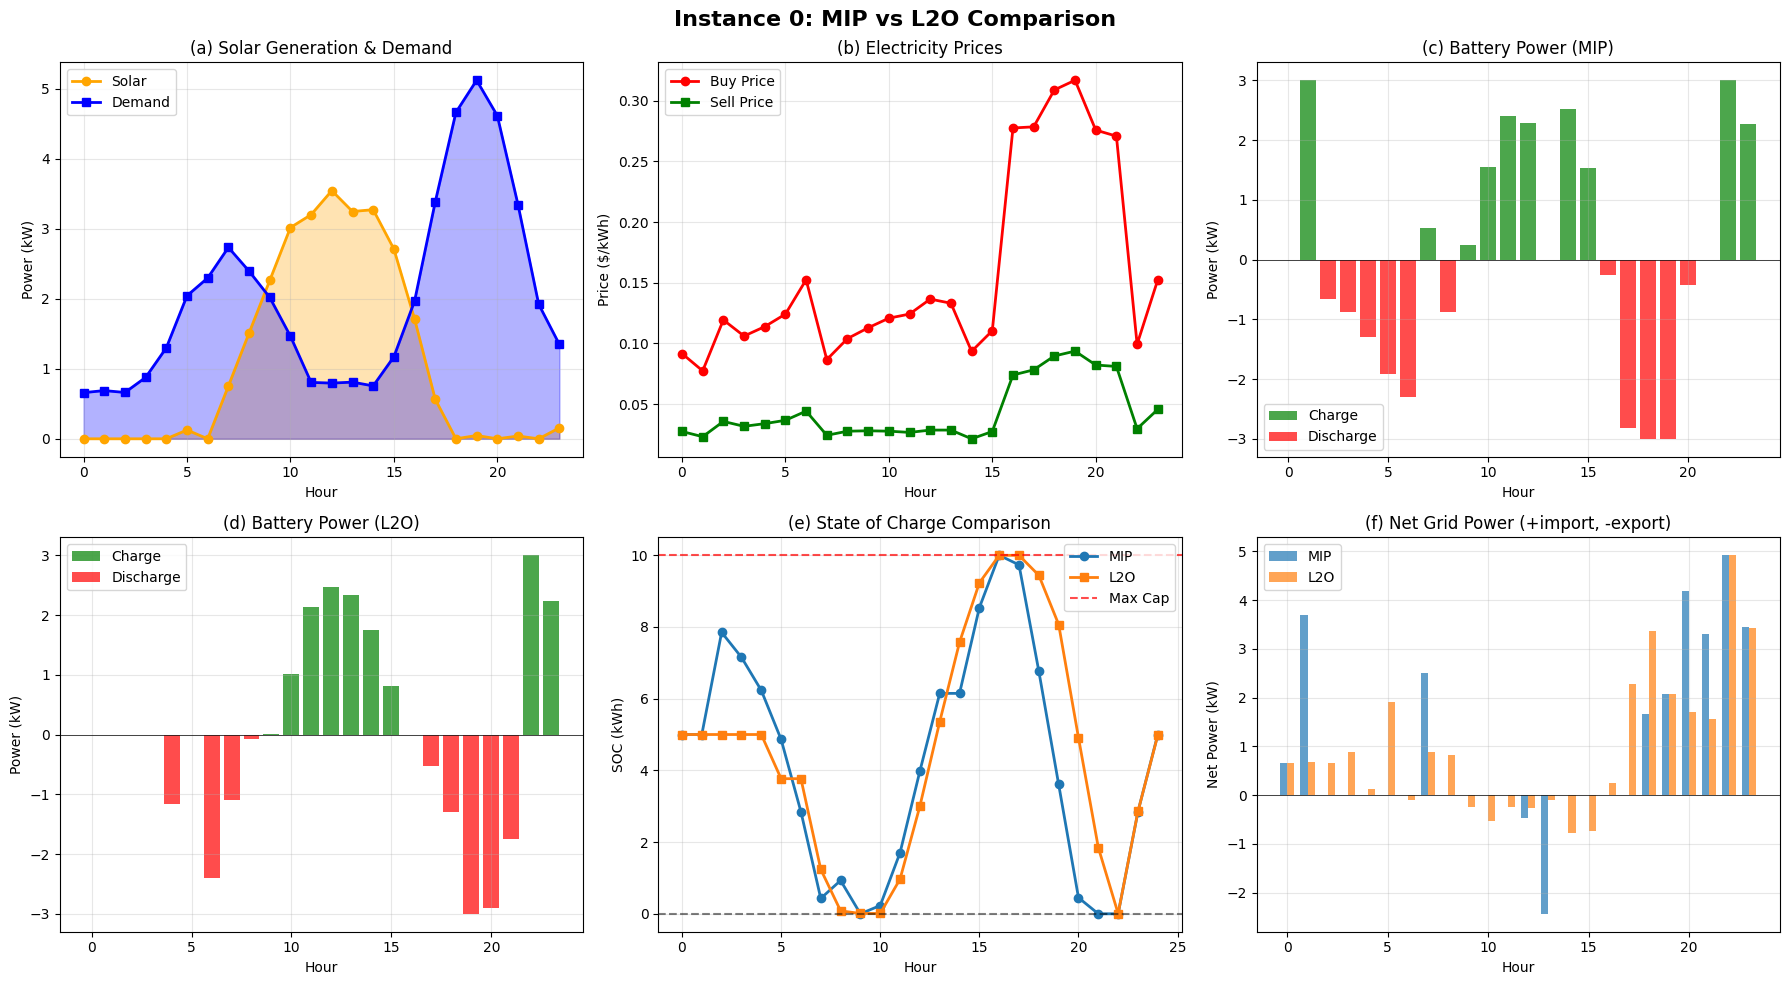

In [25]:
def plot_combined_6panel(instance_idx, test_data, comparison_results, params):
    """
    Combined 6-panel figure showing all comparison plots.
    """
    solar, demand, price_buy, price_sell = [d[instance_idx].numpy() for d in test_data]

    mip_res = comparison_results['mip_results']
    l2o_res = comparison_results['l2o_results']

    mip_charge = mip_res['power_charge'][instance_idx].numpy()
    mip_discharge = mip_res['power_discharge'][instance_idx].numpy()
    mip_soc = mip_res['soc'][instance_idx].numpy()
    mip_net = mip_res['net_power'][instance_idx].numpy()

    l2o_charge = l2o_res['power_charge'][instance_idx].numpy()
    l2o_discharge = l2o_res['power_discharge'][instance_idx].numpy()
    l2o_soc = l2o_res['soc'][instance_idx].numpy()
    l2o_net = l2o_res['net_power'][instance_idx].numpy()
    l2o_soc_full = np.concatenate([[params.initial_soc * params.battery_capacity], l2o_soc])

    hours = np.arange(24)
    hours_soc = np.arange(25)

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f'Instance {instance_idx}: MIP vs L2O Comparison', fontsize=16, fontweight='bold')

    ax = axes[0, 0]
    ax.plot(hours, solar, 'o-', label='Solar', color='orange', linewidth=2)
    ax.plot(hours, demand, 's-', label='Demand', color='blue', linewidth=2)
    ax.fill_between(hours, 0, solar, alpha=0.3, color='orange')
    ax.fill_between(hours, 0, demand, alpha=0.3, color='blue')
    ax.set_xlabel('Hour')
    ax.set_ylabel('Power (kW)')
    ax.set_title('(a) Solar Generation & Demand')
    ax.legend()
    ax.grid(True, alpha=0.3)

    ax = axes[0, 1]
    ax.plot(hours, price_buy, 'o-', label='Buy Price', color='red', linewidth=2)
    ax.plot(hours, price_sell, 's-', label='Sell Price', color='green', linewidth=2)
    ax.set_xlabel('Hour')
    ax.set_ylabel('Price ($/kWh)')
    ax.set_title('(b) Electricity Prices')
    ax.legend()
    ax.grid(True, alpha=0.3)

    ax = axes[0, 2]
    ax.bar(hours, mip_charge, label='Charge', alpha=0.7, color='green')
    ax.bar(hours, -mip_discharge, label='Discharge', alpha=0.7, color='red')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.set_xlabel('Hour')
    ax.set_ylabel('Power (kW)')
    ax.set_title('(c) Battery Power (MIP)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    ax = axes[1, 0]
    ax.bar(hours, l2o_charge, label='Charge', alpha=0.7, color='green')
    ax.bar(hours, -l2o_discharge, label='Discharge', alpha=0.7, color='red')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.set_xlabel('Hour')
    ax.set_ylabel('Power (kW)')
    ax.set_title('(d) Battery Power (L2O)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    ax = axes[1, 1]
    ax.plot(hours_soc, mip_soc, 'o-', label='MIP', linewidth=2, markersize=6, color='tab:blue')
    ax.plot(hours_soc, l2o_soc_full, 's-', label='L2O', linewidth=2, markersize=6, color='tab:orange')
    ax.axhline(y=params.battery_capacity, color='red', linestyle='--', label='Max Cap', alpha=0.7)
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax.set_xlabel('Hour')
    ax.set_ylabel('SOC (kWh)')
    ax.set_title('(e) State of Charge Comparison')
    ax.legend()
    ax.grid(True, alpha=0.3)

    ax = axes[1, 2]
    width = 0.35
    ax.bar(hours - width/2, mip_net, width, label='MIP', alpha=0.7, color='tab:blue')
    ax.bar(hours + width/2, l2o_net, width, label='L2O', alpha=0.7, color='tab:orange')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.set_xlabel('Hour')
    ax.set_ylabel('Net Power (kW)')
    ax.set_title('(f) Net Grid Power (+import, -export)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_combined_6panel(0, test_data, comparison_results, params)


### Figure 1: Battery SOC and power trajectories

This figure overlays the SOC trajectory (lines) and charging/discharging power (bars) for both MIP (blue) and L2O (orange) solutions on the same axes. The close alignment demonstrates that the L2O policy effectively learns the optimal arbitrage strategy while satisfying SOC constraints.


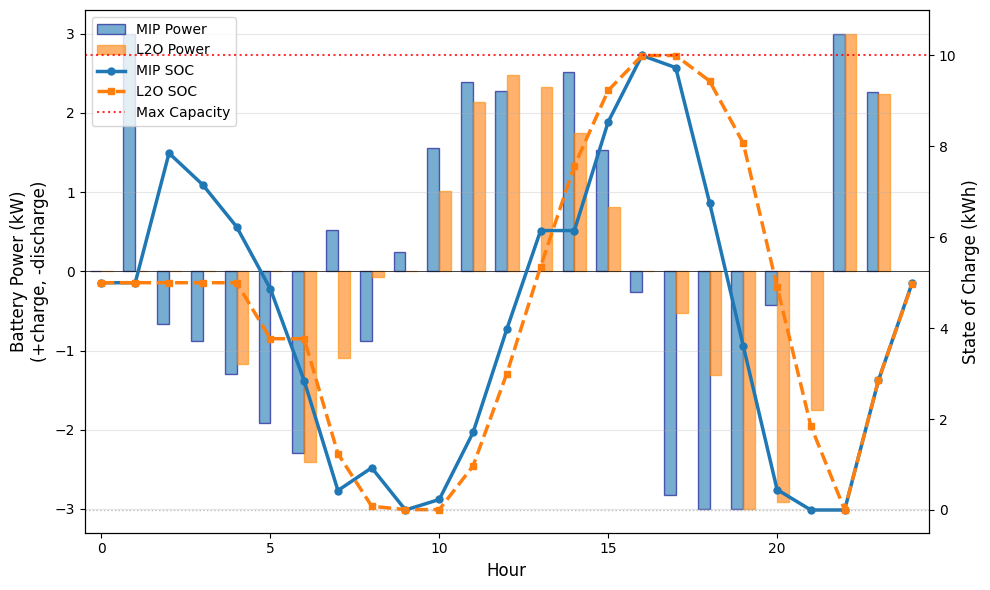

Instance 0: MIP Cost = $4.71, L2O Cost = $4.92, Gap = 4.41%


In [33]:
def plot_figure1_soc_power(instance_idx, comparison_results, params):
    """
    Figure 1: Battery SOC (solid lines) and charging/discharging power (bars)
    for MIP (blue) and L2O (orange) solutions.

    SOC and power trajectories closely align, demonstrating effective
    constraint satisfaction and arbitrage strategy.
    """
    mip_res = comparison_results['mip_results']
    l2o_res = comparison_results['l2o_results']

    mip_charge = mip_res['power_charge'][instance_idx].numpy()
    mip_discharge = mip_res['power_discharge'][instance_idx].numpy()
    mip_soc = mip_res['soc'][instance_idx].numpy()

    l2o_charge = l2o_res['power_charge'][instance_idx].numpy()
    l2o_discharge = l2o_res['power_discharge'][instance_idx].numpy()
    l2o_soc = l2o_res['soc'][instance_idx].numpy()
    l2o_soc_full = np.concatenate([[params.initial_soc * params.battery_capacity], l2o_soc])

    hours = np.arange(24)
    hours_soc = np.arange(25)

    fig, ax1 = plt.subplots(figsize=(10, 6))

    width = 0.35
    mip_power = mip_charge - mip_discharge
    l2o_power = l2o_charge - l2o_discharge

    bars_mip = ax1.bar(hours - width/2, mip_power, width, label='MIP Power',
                       alpha=0.6, color='tab:blue', edgecolor='darkblue')
    bars_l2o = ax1.bar(hours + width/2, l2o_power, width, label='L2O Power',
                       alpha=0.6, color='tab:orange', edgecolor='darkorange')

    ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax1.set_xlabel('Hour', fontsize=12)
    ax1.set_ylabel('Battery Power (kW)\n(+charge, -discharge)', fontsize=12, color='black')
    ax1.tick_params(axis='y')
    ax1.set_xlim(-0.5, 24.5)

    ax2 = ax1.twinx()
    line_mip, = ax2.plot(hours_soc, mip_soc, 'o-', label='MIP SOC',
                         linewidth=2.5, markersize=5, color='tab:blue')
    line_l2o, = ax2.plot(hours_soc, l2o_soc_full, 's--', label='L2O SOC',
                         linewidth=2.5, markersize=5, color='tab:orange')
    ax2.axhline(y=params.battery_capacity, color='red', linestyle=':',
                label='Max Capacity', alpha=0.8, linewidth=1.5)
    ax2.axhline(y=0, color='gray', linestyle=':', alpha=0.5, linewidth=1)
    ax2.set_ylabel('State of Charge (kWh)', fontsize=12)
    ax2.set_ylim(-0.5, params.battery_capacity + 1)

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)


    ax1.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    mip_cost = comparison_results['mip_costs'][instance_idx].item()
    l2o_cost = comparison_results['l2o_costs'][instance_idx].item()
    gap = comparison_results['cost_gaps'][instance_idx].item()
    print(f"Instance {instance_idx}: MIP Cost = ${mip_cost:.2f}, L2O Cost = ${l2o_cost:.2f}, Gap = {gap:.2f}%")

plot_figure1_soc_power(0, comparison_results, params)


### Figure 2: Exogenous inputs driving battery behavior

This figure shows the electricity prices, solar generation, and demand profile for the same day as Figure 1. The battery behavior in Figure 1 is driven by these time-dependent signals:
- **Charge** during low-price periods (off-peak) and high solar generation.
- **Discharge** during high-price periods (evening peak) when demand exceeds solar.


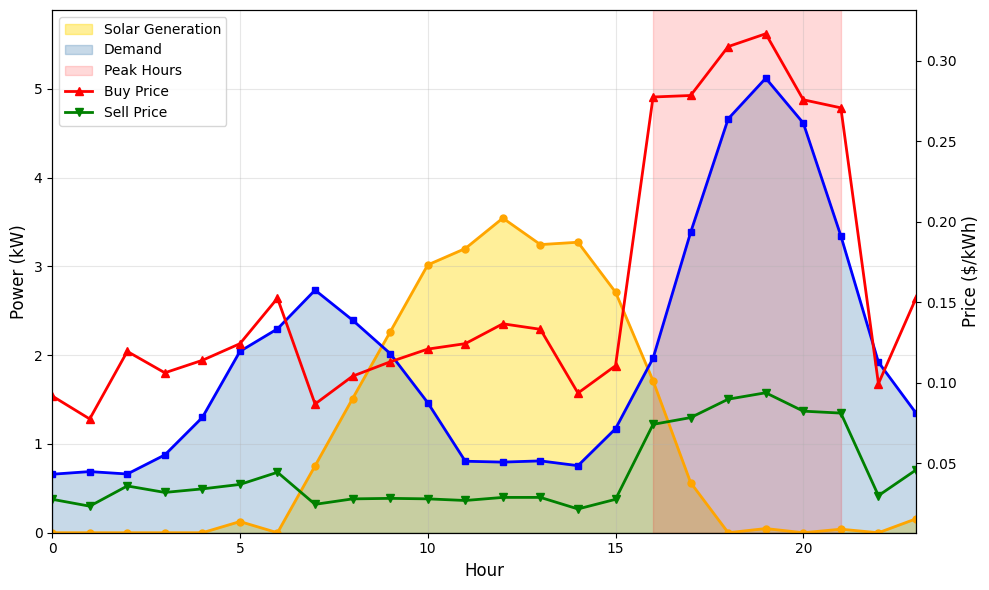

In [32]:
def plot_figure2_inputs(instance_idx, test_data):
    """
    Figure 2: Electricity prices, solar generation, and demand for the same day.

    The battery behavior in Figure 1 is driven by these time-dependent signals.
    """
    solar, demand, price_buy, price_sell = [d[instance_idx].numpy() for d in test_data]
    hours = np.arange(24)

    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.fill_between(hours, 0, solar, alpha=0.4, color='gold', label='Solar Generation')
    ax1.plot(hours, solar, 'o-', color='orange', linewidth=2, markersize=5)
    ax1.fill_between(hours, 0, demand, alpha=0.3, color='steelblue', label='Demand')
    ax1.plot(hours, demand, 's-', color='blue', linewidth=2, markersize=5)

    ax1.set_xlabel('Hour', fontsize=12)
    ax1.set_ylabel('Power (kW)', fontsize=12)
    ax1.set_xlim(0, 23)
    ax1.set_ylim(0, max(solar.max(), demand.max()) * 1.15)

    ax2 = ax1.twinx()
    ax2.plot(hours, price_buy, '^-', label='Buy Price', color='red',
             linewidth=2, markersize=6)
    ax2.plot(hours, price_sell, 'v-', label='Sell Price', color='green',
             linewidth=2, markersize=6)
    ax2.set_ylabel('Price ($/kWh)', fontsize=12)

    peak_start, peak_end = 16, 21
    ax1.axvspan(peak_start, peak_end, alpha=0.15, color='red', label='Peak Hours')

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)


    ax1.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_figure2_inputs(0, test_data)


### Figure 3: Optimality gap distribution across test instances

This figure shows the distribution of optimality gaps (L2O cost relative to MIP) across all test instances. A well-trained L2O model should have:
- **Mean gap** close to zero (near-optimal on average).
- **Tight distribution** (consistent performance across scenarios).
- **Few outliers** (robust to diverse inputs).


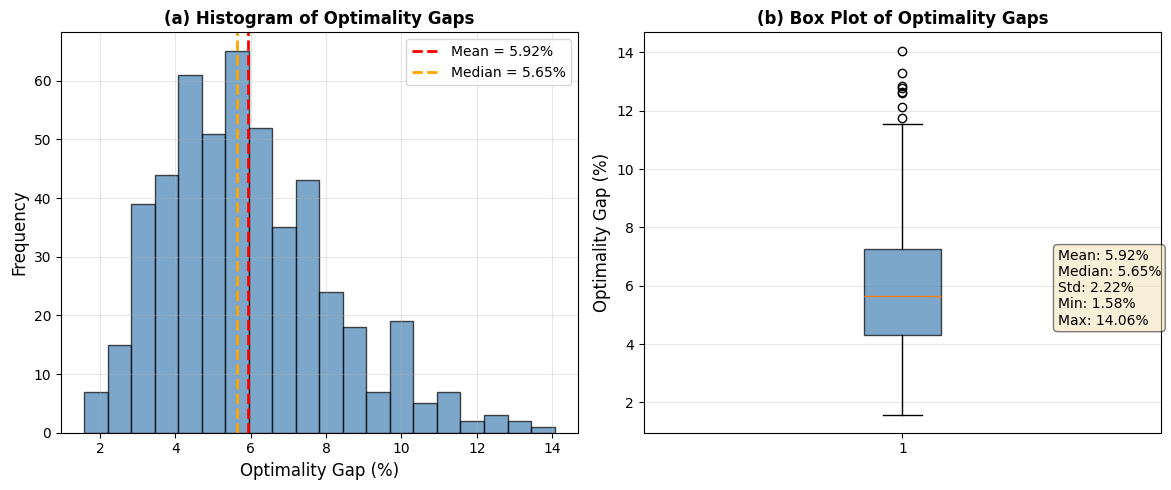

In [35]:
def plot_figure3_gap_distribution(comparison_results):
    """
    Figure 3: Distribution of optimality gaps across all test instances.
    """
    cost_gaps = comparison_results['cost_gaps'].numpy()

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    ax = axes[0]
    ax.hist(cost_gaps, bins=20, edgecolor='black', alpha=0.7, color='steelblue')
    ax.axvline(x=cost_gaps.mean(), color='red', linestyle='--', linewidth=2,
               label=f'Mean = {cost_gaps.mean():.2f}%')
    ax.axvline(x=np.median(cost_gaps), color='orange', linestyle='--', linewidth=2,
               label=f'Median = {np.median(cost_gaps):.2f}%')
    ax.set_xlabel('Optimality Gap (%)', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title('(a) Histogram of Optimality Gaps', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

    ax = axes[1]
    bp = ax.boxplot(cost_gaps, vert=True, patch_artist=True)
    bp['boxes'][0].set_facecolor('steelblue')
    bp['boxes'][0].set_alpha(0.7)
    ax.set_ylabel('Optimality Gap (%)', fontsize=12)
    ax.set_title('(b) Box Plot of Optimality Gaps', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

    stats_text = (f"Mean: {cost_gaps.mean():.2f}%\n"
                  f"Median: {np.median(cost_gaps):.2f}%\n"
                  f"Std: {cost_gaps.std():.2f}%\n"
                  f"Min: {cost_gaps.min():.2f}%\n"
                  f"Max: {cost_gaps.max():.2f}%")
    ax.text(1.3, cost_gaps.mean(), stats_text, fontsize=10, verticalalignment='center',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))


    plt.tight_layout()
    plt.show()

plot_figure3_gap_distribution(comparison_results)


### Detailed hourly comparison table

The `print_hourly_comparison_table` function produces a detailed spreadsheet-style table showing:

- **Exogenous parameters** (solar, demand, prices) for each hour.
- **MIP solution** (operating mode, charge, discharge, SOC, net grid power).
- **L2O solution** (same format).
- **Mode agreement** marker (✓ or ✗).

In [38]:
def print_hourly_comparison_table(instance_idx, test_data, comparison_results, params):

    solar, demand, price_buy, price_sell = [d[instance_idx].numpy() for d in test_data]

    mip_res = comparison_results['mip_results']
    l2o_res = comparison_results['l2o_results']

    mip_charge = mip_res['power_charge'][instance_idx].numpy()
    mip_discharge = mip_res['power_discharge'][instance_idx].numpy()
    mip_soc = mip_res['soc'][instance_idx].numpy()
    mip_net = mip_res['net_power'][instance_idx].numpy()
    mip_mode = mip_res['mode'][instance_idx].numpy()

    l2o_charge = l2o_res['power_charge'][instance_idx].numpy()
    l2o_discharge = l2o_res['power_discharge'][instance_idx].numpy()
    l2o_soc = l2o_res['soc'][instance_idx].numpy()
    l2o_net = l2o_res['net_power'][instance_idx].numpy()
    l2o_mode = l2o_res['mode'][instance_idx].numpy()

    def get_mode_string(mode_vec):
        if mode_vec[0] > 0.5:
            return "CHARGE"
        elif mode_vec[1] > 0.5:
            return "DISCHARGE"
        else:
            return "IDLE"

    print("\n" + "="*150)
    print(f"HOURLY COMPARISON TABLE - INSTANCE {instance_idx}")
    print("="*150)

    print(f"{'Hour':>4} | {'Solar':>6} | {'Demand':>6} | {'Buy$':>6} | {'Sell$':>6} || "
          f"{'MIP':^9} | {'MIP':>7} | {'MIP':>7} | {'MIP':>6} | {'MIP':>7} || "
          f"{'L2O':^9} | {'L2O':>7} | {'L2O':>7} | {'L2O':>6} | {'L2O':>7}")
    print(f"{'':>4} | {'(kW)':>6} | {'(kW)':>6} | {'($/k)':>6} | {'($/k)':>6} || "
          f"{'Mode':^9} | {'Chg(kW)':>7} | {'Dis(kW)':>7} | {'SOC':>6} | {'Net(kW)':>7} || "
          f"{'Mode':^9} | {'Chg(kW)':>7} | {'Dis(kW)':>7} | {'SOC':>6} | {'Net(kW)':>7}")
    print("-"*150)

    for h in range(24):
        mip_mode_str = get_mode_string(mip_mode[h])
        l2o_mode_str = get_mode_string(l2o_mode[h])
        mode_match = "✓" if mip_mode_str == l2o_mode_str else "✗"

        print(f"{h:4d} | {solar[h]:6.2f} | {demand[h]:6.2f} | {price_buy[h]:6.3f} | {price_sell[h]:6.3f} || "
              f"{mip_mode_str:^9} | {mip_charge[h]:7.2f} | {mip_discharge[h]:7.2f} | {mip_soc[h+1]:6.2f} | {mip_net[h]:7.2f} || "
              f"{l2o_mode_str:^9} | {l2o_charge[h]:7.2f} | {l2o_discharge[h]:7.2f} | {l2o_soc[h]:6.2f} | {l2o_net[h]:7.2f} | {mode_match}")

    print("="*150)

    mip_total_charge = mip_charge.sum()
    mip_total_discharge = mip_discharge.sum()
    l2o_total_charge = l2o_charge.sum()
    l2o_total_discharge = l2o_discharge.sum()

    mip_charge_hours = (mip_charge > 0.01).sum()
    mip_discharge_hours = (mip_discharge > 0.01).sum()
    mip_idle_hours = 24 - mip_charge_hours - mip_discharge_hours

    l2o_charge_hours = (l2o_charge > 0.01).sum()
    l2o_discharge_hours = (l2o_discharge > 0.01).sum()
    l2o_idle_hours = 24 - l2o_charge_hours - l2o_discharge_hours

    mip_import = np.maximum(0, mip_net).sum()
    mip_export = np.maximum(0, -mip_net).sum()
    l2o_import = np.maximum(0, l2o_net).sum()
    l2o_export = np.maximum(0, -l2o_net).sum()

    mode_agreement = sum([get_mode_string(mip_mode[h]) == get_mode_string(l2o_mode[h]) for h in range(24)])


print_hourly_comparison_table(
    instance_idx,
    test_data,
    comparison_results,
    params
)


HOURLY COMPARISON TABLE - INSTANCE 0
Hour |  Solar | Demand |   Buy$ |  Sell$ ||    MIP    |     MIP |     MIP |    MIP |     MIP ||    L2O    |     L2O |     L2O |    L2O |     L2O
     |   (kW) |   (kW) |  ($/k) |  ($/k) ||   Mode    | Chg(kW) | Dis(kW) |    SOC | Net(kW) ||   Mode    | Chg(kW) | Dis(kW) |    SOC | Net(kW)
------------------------------------------------------------------------------------------------------------------------------------------------------
   0 |   0.00 |   0.81 |  0.096 |  0.029 || DISCHARGE |    0.00 |    0.81 |   4.15 |    0.00 ||  CHARGE   |    0.00 |    0.00 |   5.00 |    0.81 | ✗
   1 |   0.00 |   0.71 |  0.135 |  0.040 || DISCHARGE |    0.00 |    0.71 |   3.41 |    0.00 ||   IDLE    |    0.00 |    0.00 |   5.00 |    0.71 | ✗
   2 |   0.00 |   0.91 |  0.168 |  0.050 || DISCHARGE |    0.00 |    0.91 |   2.45 |    0.00 ||   IDLE    |    0.00 |    0.00 |   5.00 |    0.91 | ✗
   3 |   0.00 |   0.96 |  0.093 |  0.028 ||   IDLE    |    0.00 |    0.00 